In [ ]:
from typing import Tuple
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import Dataset, DataLoader


import torch
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib as plt
import zipfile
import requests
import io
import os

In [ ]:
flicker_dir = Path("../data/flicker")
augmented_dir = Path("../data/augmented")
augmented_dir_no = Path("../data/augmented_no")
augmented_dir_2 = Path("../data/augmented_2")

flicker_dir.mkdir(parents=True, exist_ok=True)
augmented_dir.mkdir(parents=True, exist_ok=True)
data_dir = Path("../data/final_dataset")

In [ ]:
# '''Get dataset from flicker'''
# # url = "https://www.lirmm.fr/~poncelet/Ressources/flickr_subset2.zip"
# url_augmented = "https://www.lirmm.fr/~poncelet/Ressources/flickr_long_subset.zip"
# print("Requesting...\n")
# response = requests.get(url_augmented)
# if response.status_code == 200:
#     print("Téléchargement réussi. Extraction...")
#     with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
#         # Extraire sans ajouter de sous-dossier supplémentaire
#         for member in zip_ref.namelist():
#             # Corrige les chemins pour ignorer un éventuel prefixe flickr_subset2/
#             member_path = member
#             if member.startswith("flickr_subset2/"):
#                 member_path = member[len("flickr_subset2/"):]
#             target_path = flicker_dir / member_path

#             # Si c'est un répertoire, on le crée
#             if member.endswith("/"):
#                 target_path.mkdir(exist_ok=True, parents=True)
#             else:
#                 os.makedirs(os.path.dirname(target_path), exist_ok=True)
#                 with zip_ref.open(member) as source, open(target_path, "wb") as target:
#                     target.write(source.read())
#     print(f"Données extraites dans : {flicker_dir}")
# else:
#     print("Échec du téléchargement. Code HTTP :", response.status_code)


In [ ]:
!ls ..

In [55]:
metadata_path = data_dir / "metadata.csv"
df = pd.read_csv(metadata_path)
print(df.columns)
print(df.iloc[0])

Index(['image_path', 'label', 'caption'], dtype='object')
image_path                                     new_ball_683.jpg
label                                                Label.BALL
caption       Two black dogs, their fur fluffed up in agitat...
Name: 0, dtype: object


In [122]:
import re
def get_label(filename: str):
    return filename.split("_")[0]


def get_uuid(filename: str):
    name = Path(filename).stem          
    parts = name.split("_")
    return "_".join(parts[:2])          


def build_augmented_path(img_path: Path, base_dir: Path):
    img_path = Path(img_path)
    filename = img_path.name
    label = get_label(filename)
    uuid = get_uuid(filename)
    print(filename)

    base = re.sub(
        r"^(new|base)_|_(color|spatial)(?=\.)|\.[^.]+$",
        "",
        filename
    )
    print(base)
    print("\n")

    print(base_dir / uuid / base / filename)
    return base_dir / uuid / base / filename

get_label(df["image_path"].iloc[1])
get_uuid(df["image_path"].iloc[1])

print(build_augmented_path(df["image_path"].iloc[1], data_dir))

new_ball_683_spatial.jpg
ball_683


../data/final_dataset/new_ball/ball_683/new_ball_683_spatial.jpg
../data/final_dataset/new_ball/ball_683/new_ball_683_spatial.jpg


In [123]:
from torchvision import transforms

transform = transforms.Compose(
    [transforms.Resize((300, 500)),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class ImageCLIPDataset(Dataset):
    def __init__(self, imgs, labels, base_dir: Path, transform):
        
        self.img_paths = [Path(build_augmented_path(img, base_dir)) for img in imgs]
        self.labels = labels
        self.transform = transform
        self.classes = sorted(set(self.labels))                  
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}  



    def __getitem__(self, idx) -> Tuple[Image.Image, str]:
        img = Image.open(self.img_paths[idx]).convert("RGB")
        label_str = self.labels[idx]
        label = self.class_to_idx[label_str]   

        if self.transform:
            img = self.transform(img)
        return idx, img, label
    
    def __len__(self) -> int:
        return len(self.img_paths)
    
    def _get_img_path_from_idx(self, idx: int) -> Path:
        return self.img_paths[idx]
    
    def _get_label_from_idx(self, idx: int) -> str :
        return self.labels[idx]
    
    def _get_img_size(self, idx: int) -> Tuple[int, int]:
        print(self.img_paths[idx])

        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            for t in self.transform.transforms:
                if isinstance(t, transforms.Resize):
                    img = t(img)
        return img.height, img.width

    
    
    

        


In [124]:
X =  df["image_path"]
print(X)

0                new_ball_683.jpg
1        new_ball_683_spatial.jpg
2          new_ball_683_color.jpg
3                new_ball_196.jpg
4        new_ball_196_spatial.jpg
                  ...            
4195    base_ball_031_spatial.jpg
4196      base_ball_031_color.jpg
4197            base_ball_137.jpg
4198    base_ball_137_spatial.jpg
4199      base_ball_137_color.jpg
Name: image_path, Length: 4200, dtype: object


In [125]:

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=11)
df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=11)

print(len(df_train), len(df_test), len(df_val))
print(df_train["label"].value_counts(normalize=True) * 100)
print(df_val["label"].value_counts(normalize=True) * 100)
print(df_test["label"].value_counts(normalize=True) * 100)


2940 630 630
label
Label.BALL     25.782313
Label.WATER    24.897959
Label.DOG      24.761905
Label.BIKE     24.557823
Name: proportion, dtype: float64
label
Label.WATER    26.666667
Label.DOG      25.079365
Label.BALL     24.285714
Label.BIKE     23.968254
Name: proportion, dtype: float64
label
Label.BIKE     28.095238
Label.DOG      26.031746
Label.WATER    23.809524
Label.BALL     22.063492
Name: proportion, dtype: float64


In [126]:
X_train, y_train = df_train["image_path"], df_train["label"]
X_val, y_val     = df_val["image_path"], df_val["label"]
X_test, y_test   = df_test["image_path"], df_test["label"]


In [127]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [128]:
train_dataset = ImageCLIPDataset(X_train, y_train, data_dir, transform_resnet)
val_dataset   = ImageCLIPDataset(X_val, y_val, data_dir, transform_resnet)
test_dataset  = ImageCLIPDataset(X_test, y_test, data_dir, transform_resnet)


base_ball_070_color.jpg
ball_070


../data/final_dataset/base_ball/ball_070/base_ball_070_color.jpg
new_bike_097_spatial.jpg
bike_097


../data/final_dataset/new_bike/bike_097/new_bike_097_spatial.jpg
base_bike_059_color.jpg
bike_059


../data/final_dataset/base_bike/bike_059/base_bike_059_color.jpg
base_bike_025.jpg
bike_025


../data/final_dataset/base_bike/bike_025/base_bike_025.jpg
new_bike_191.jpg
bike_191


../data/final_dataset/new_bike/bike_191/new_bike_191.jpg
new_dog_662_color.jpg
dog_662


../data/final_dataset/new_dog/dog_662/new_dog_662_color.jpg
new_bike_158_color.jpg
bike_158


../data/final_dataset/new_bike/bike_158/new_bike_158_color.jpg
new_ball_459_color.jpg
ball_459


../data/final_dataset/new_ball/ball_459/new_ball_459_color.jpg
new_dog_1071_color.jpg
dog_1071


../data/final_dataset/new_dog/dog_1071/new_dog_1071_color.jpg
new_ball_107.jpg
ball_107


../data/final_dataset/new_ball/ball_107/new_ball_107.jpg
base_ball_018_spatial.jpg
ball_018


../data/final_dataset/

../data/final_dataset/base_bike/bike_025/base_bike_025.jpg
(224, 224)
../data/final_dataset/new_dog/dog_1013/new_dog_1013_color.jpg
(224, 224)
base_bike_025.jpg
bike_025


../data/final_dataset/base_bike/bike_025/base_bike_025.jpg


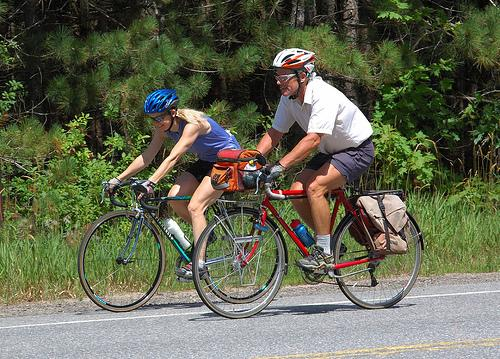

(3, tensor([[[-1.7069, -1.9980, -1.9124,  ..., -1.4329, -1.3302, -1.7583],
         [-1.5699, -1.6727, -1.6898,  ..., -0.8678, -0.9363, -1.6727],
         [-1.0390, -1.0733, -1.1418,  ...,  0.0398, -1.0048, -1.5699],
         ...,
         [ 0.8618,  1.0502,  0.9646,  ...,  0.9988,  0.9646,  1.0844],
         [ 0.7762,  0.9303,  0.9817,  ...,  1.0331,  0.9817,  0.8104],
         [ 0.7933,  0.9817,  0.9474,  ...,  1.1529,  1.0159,  0.8276]],

        [[-1.3880, -1.7381, -1.7031,  ..., -1.3880, -1.2829, -1.7206],
         [-1.2304, -1.3704, -1.4580,  ..., -0.7402, -0.8277, -1.5805],
         [-0.6527, -0.7577, -0.9328,  ...,  0.2752, -0.8277, -1.3880],
         ...,
         [ 1.0630,  1.2556,  1.1681,  ...,  1.2031,  1.1856,  1.3081],
         [ 0.9755,  1.1331,  1.1856,  ...,  1.2381,  1.2031,  1.0280],
         [ 0.9930,  1.1856,  1.1506,  ...,  1.3431,  1.2381,  1.0455]],

        [[-1.4559, -1.7522, -1.6824,  ..., -1.2990, -1.2467, -1.6476],
         [-1.3513, -1.4733, -1.5081,  ...

In [129]:
print(train_dataset._get_img_size(3))
print(train_dataset._get_img_size(13))
img = train_dataset._get_img_path_from_idx(3)
lg = Image.open(build_augmented_path(img, data_dir))
display(lg)
print(train_dataset.__getitem__(3))

In [132]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [133]:
class CNNBasic(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2)
        )

        self.flattened_size = self._get_flattened_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 300, 500)
            x = self.features(x)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [134]:
model = CNNBasic(4)

In [135]:
model

CNNBasic(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=146816, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_

In [136]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [137]:
print(len(train_dataset))
print(len(test_dataset))

2940
630


In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)
EPOCHS = 11

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    loop = tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch+1}/10 [TRAIN]")
    for i, data in loop:
        idx, inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss/(i+1))

    avg_train_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} - Average TRAIN loss: {avg_train_loss:.4f}")


    model.eval()
    running_test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/10 [EVAL]")
        for idx, inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = running_test_loss / len(test_loader)
    print(f"Epoch {epoch+1} - Average TEST loss: {avg_test_loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=3))




Epoch 1/10 [TRAIN]:   0%|          | 0/92 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x50176 and 146816x256)

In [141]:
from torchvision.models import resnet18, ResNet18_Weights
num_classes = 4

model_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # <--- ajoute compatibilité toutes tailles

model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-4, weight_decay=1e-5)



In [142]:
from sklearn.metrics import classification_report


def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0

    for idx, inputs, labels in tqdm(loader, desc="TRAIN", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


def evaluate(model, loader, name="VALID"):
    model.eval()
    preds, targets = [], []
    running_loss = 0.0

    with torch.no_grad():
        for idx, inputs, labels in tqdm(loader, desc=name, leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = outputs.argmax(dim=1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    print(f"\n{name} loss: {avg_loss:.4f}")
    print(f"{name} classification report:\n",
          classification_report(targets, preds, digits=3))

    return avg_loss


# ============================================
# Training Loop
# ============================================
EPOCHS = 11  # à ajuster
for epoch in range(1, EPOCHS + 1):
    print(f"\n========== Epoch {epoch}/{EPOCHS} ==========")
    train_loss = train_one_epoch(model_resnet, train_loader)
    print(f"Train loss: {train_loss:.4f}")
    evaluate(model_resnet, val_loader)


========== Epoch 1/11 ==========


Train loss: 0.6700



VALID loss: 0.4425
VALID classification report:
               precision    recall  f1-score   support

           0      0.787     0.771     0.779       153
           1      0.896     0.967     0.930       151
           2      0.728     0.848     0.784       158
           3      0.917     0.726     0.811       168

    accuracy                          0.825       630
   macro avg      0.832     0.828     0.826       630
weighted avg      0.833     0.825     0.825       630


========== Epoch 2/11 ==========


Train loss: 0.1483



VALID loss: 0.3135
VALID classification report:
               precision    recall  f1-score   support

           0      0.808     0.908     0.855       153
           1      0.961     0.974     0.967       151
           2      0.851     0.797     0.824       158
           3      0.917     0.857     0.886       168

    accuracy                          0.883       630
   macro avg      0.884     0.884     0.883       630
weighted avg      0.885     0.883     0.882       630


========== Epoch 3/11 ==========


Train loss: 0.0610



VALID loss: 0.3209
VALID classification report:
               precision    recall  f1-score   support

           0      0.873     0.895     0.884       153
           1      0.955     0.980     0.967       151
           2      0.889     0.810     0.848       158
           3      0.891     0.923     0.906       168

    accuracy                          0.902       630
   macro avg      0.902     0.902     0.901       630
weighted avg      0.901     0.902     0.901       630


========== Epoch 4/11 ==========


Train loss: 0.0364



VALID loss: 0.3265
VALID classification report:
               precision    recall  f1-score   support

           0      0.882     0.882     0.882       153
           1      0.967     0.967     0.967       151
           2      0.857     0.835     0.846       158
           3      0.895     0.917     0.906       168

    accuracy                          0.900       630
   macro avg      0.900     0.900     0.900       630
weighted avg      0.900     0.900     0.900       630


========== Epoch 5/11 ==========


Train loss: 0.0233



VALID loss: 0.3553
VALID classification report:
               precision    recall  f1-score   support

           0      0.863     0.863     0.863       153
           1      0.967     0.974     0.970       151
           2      0.831     0.810     0.821       158
           3      0.901     0.917     0.909       168

    accuracy                          0.890       630
   macro avg      0.890     0.891     0.891       630
weighted avg      0.890     0.890     0.890       630


========== Epoch 6/11 ==========


Train loss: 0.0210



VALID loss: 0.3414
VALID classification report:
               precision    recall  f1-score   support

           0      0.856     0.895     0.875       153
           1      0.949     0.980     0.964       151
           2      0.862     0.829     0.845       158
           3      0.914     0.881     0.897       168

    accuracy                          0.895       630
   macro avg      0.895     0.896     0.895       630
weighted avg      0.895     0.895     0.895       630


========== Epoch 7/11 ==========


Train loss: 0.0169



VALID loss: 0.3279
VALID classification report:
               precision    recall  f1-score   support

           0      0.875     0.869     0.872       153
           1      0.961     0.980     0.970       151
           2      0.847     0.842     0.844       158
           3      0.904     0.899     0.901       168

    accuracy                          0.897       630
   macro avg      0.897     0.897     0.897       630
weighted avg      0.896     0.897     0.897       630


========== Epoch 8/11 ==========


Train loss: 0.0139



VALID loss: 0.3576
VALID classification report:
               precision    recall  f1-score   support

           0      0.868     0.863     0.866       153
           1      0.973     0.967     0.970       151
           2      0.835     0.835     0.835       158
           3      0.894     0.905     0.899       168

    accuracy                          0.892       630
   macro avg      0.893     0.892     0.893       630
weighted avg      0.892     0.892     0.892       630


========== Epoch 9/11 ==========


Train loss: 0.0171



VALID loss: 0.3915
VALID classification report:
               precision    recall  f1-score   support

           0      0.891     0.856     0.873       153
           1      0.949     0.980     0.964       151
           2      0.846     0.835     0.841       158
           3      0.883     0.899     0.891       168

    accuracy                          0.892       630
   macro avg      0.892     0.893     0.892       630
weighted avg      0.892     0.892     0.892       630


========== Epoch 10/11 ==========


Train loss: 0.0186



VALID loss: 0.4223
VALID classification report:
               precision    recall  f1-score   support

           0      0.901     0.837     0.868       153
           1      0.960     0.960     0.960       151
           2      0.799     0.880     0.837       158
           3      0.914     0.887     0.900       168

    accuracy                          0.890       630
   macro avg      0.894     0.891     0.891       630
weighted avg      0.893     0.890     0.891       630


========== Epoch 11/11 ==========


Train loss: 0.0151



VALID loss: 0.3928
VALID classification report:
               precision    recall  f1-score   support

           0      0.892     0.863     0.877       153
           1      0.943     0.980     0.961       151
           2      0.860     0.816     0.838       158
           3      0.897     0.935     0.915       168

    accuracy                          0.898       630
   macro avg      0.898     0.898     0.898       630
weighted avg      0.897     0.898     0.898       630



In [143]:
class ResNet18EarlyExit(nn.Module):
    def __init__(self, num_classes=4, threshold=0.9):
        super().__init__()
        self.threshold = threshold

        base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.stem = nn.Sequential(
            base.conv1, base.bn1, base.relu, base.maxpool
        )
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        
        self.exit1 = self._make_exit(64, num_classes)
        self.exit2 = self._make_exit(128, num_classes)
        self.exit3 = self._make_exit(256, num_classes)
        self.exit4 = nn.Linear(base.fc.in_features, num_classes)

    def _make_exit(self, channels, num_classes):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(channels, num_classes)
        )
    def extract_features(self, x):
        features = {}

        x = self.stem(x)
        x = self.layer1(x)
        f1 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit1"] = f1

        x = self.layer2(x)
        f2 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit2"] = f2

        x = self.layer3(x)
        f3 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit3"] = f3

        x = self.layer4(x)
        f4 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit4"] = f4

        return features
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        out1 = self.exit1(x)
        if self._confident(out1):
            return out1
        
        x = self.layer2(x)
        out2 = self.exit2(x)
        if self._confident(out2):
            return out2
        
        x = self.layer3(x)
        out3 = self.exit3(x)
        if self._confident(out3):
            return out3
        
        x = self.layer4(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = torch.flatten(x, 1)
        out4 = self.exit4(x)
        return out4, 4

    def _confident(self, logits):
        probs = logits.softmax(dim=1)
        max_conf = probs.max(dim=1).values
        return (max_conf > self.threshold).any()


In [144]:
model_resnet_custom = ResNet18EarlyExit()
model_resnet_custom = model_resnet_custom.to(device)

In [145]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet_custom.parameters(), lr=1e-4, weight_decay=1e-5)

for epoch in range(5):
    model_resnet_custom.train()
    running_loss = 0.0
    for idx, inputs, labels in tqdm(train_loader, desc=f"TRAIN {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model_resnet_custom(inputs)

        if isinstance(output, tuple):
            logits = output[0]
        else:
            logits = output

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}: Train loss = {running_loss/len(train_loader):.4f}")


TRAIN 1: 100%|██████████| 92/92 [00:17<00:00,  5.15it/s]


Epoch 1: Train loss = 0.6841


TRAIN 2: 100%|██████████| 92/92 [00:17<00:00,  5.16it/s]


Epoch 2: Train loss = 0.1690


TRAIN 3: 100%|██████████| 92/92 [00:17<00:00,  5.19it/s]


Epoch 3: Train loss = 0.0592


TRAIN 4: 100%|██████████| 92/92 [00:17<00:00,  5.17it/s]


Epoch 4: Train loss = 0.0365


TRAIN 5: 100%|██████████| 92/92 [00:17<00:00,  5.17it/s]

Epoch 5: Train loss = 0.0240


In [146]:
def predict_image(model, img_tensor, class_names):
    model.eval()
    with torch.no_grad():
        logits, exit_id = model(img_tensor.unsqueeze(0).to(device))
        probs = logits.softmax(dim=1)
        confidence, pred = torch.max(probs, dim=1)
        return class_names[pred.item()], confidence.item(), exit_id

img, label = val_dataset[0][1], val_dataset[0][2]  

print(val_dataset._get_label_from_idx(0))

class_names = ["Label.BALL", "Label.BIKE", "Label.DOG", "Label.WATER"]

pred, conf, exit_used = predict_image(model_resnet_custom, img, class_names)
print("Prediction:", pred)
print("Confidence:", round(conf, 3))
print("Exit used:", exit_used)


Label.BIKE
Prediction: Label.BALL
Confidence: 0.82
Exit used: 4


In [147]:

from sklearn.metrics import classification_report


def evaluate(model, loader, name="VAL"):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    eval_loss = 0.0

    with torch.no_grad():
        for idx, inputs, labels in tqdm(loader, desc=f"{name}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            output = model(inputs)
            if isinstance(output, torch.Tensor):
                print("hello")
                logits = output
            elif isinstance(output, (list, tuple)):
                logits = next((o for o in output if isinstance(o, torch.Tensor)), None)

            logits = output[0] if isinstance(output, tuple) else output

            loss = criterion(logits, labels)
            eval_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = eval_loss / len(loader)
    print(f"\n{name} Loss: {avg_loss:.4f}")
    print(f"{name} Classification Report:\n",
          classification_report(all_labels, all_preds, digits=3))

    return avg_loss, all_labels, all_probs


In [152]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
_, y_true, y_prob = evaluate(model_resnet_custom, val_loader, name="TEST")

# Classes (assure-toi que l'ordre correspond à l'entraînement)
class_names = ["Label.BALL", "Label.BIKE", "Label.WATER", "Label.DOG"]
n_classes = len(class_names)

# Binarisation One-vs-Rest
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
y_prob = np.array(y_prob)

# ROC par classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


TEST Loss: 0.3142
TEST Classification Report:
               precision    recall  f1-score   support

           0      0.841     0.935     0.885       153
           1      0.943     0.987     0.964       151
           2      0.919     0.791     0.850       158
           3      0.904     0.893     0.898       168

    accuracy                          0.900       630
   macro avg      0.902     0.901     0.900       630
weighted avg      0.902     0.900     0.899       630



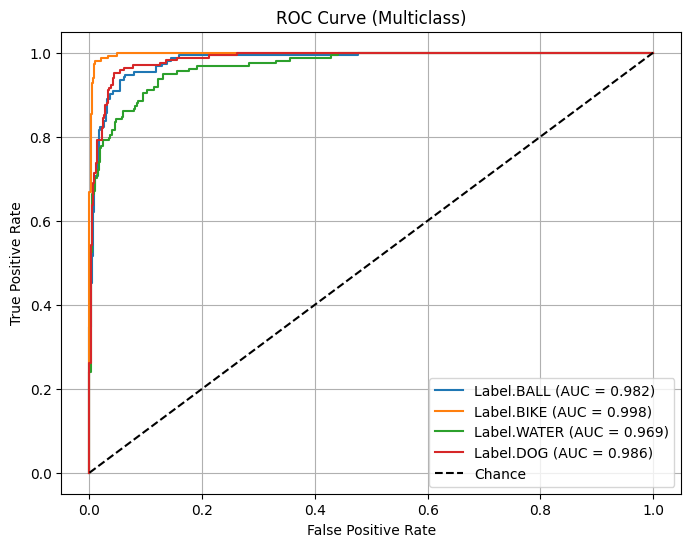

In [154]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



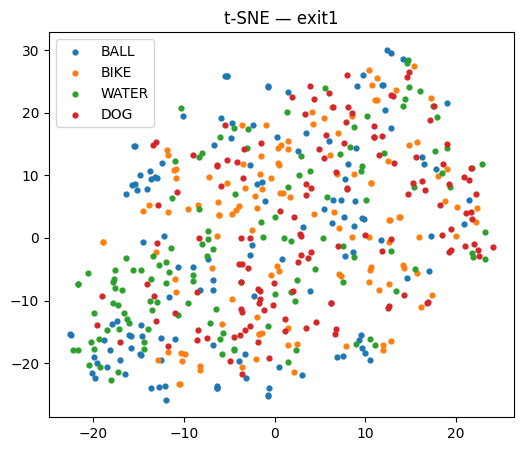

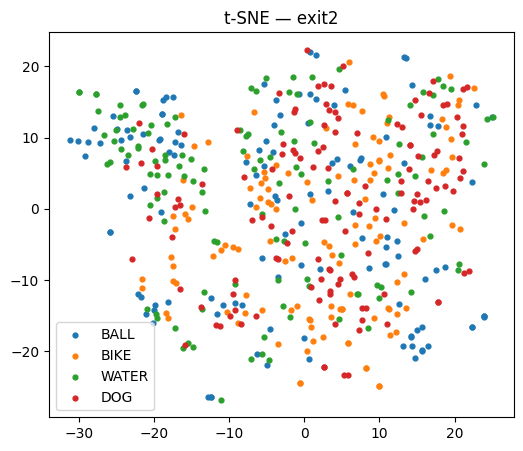

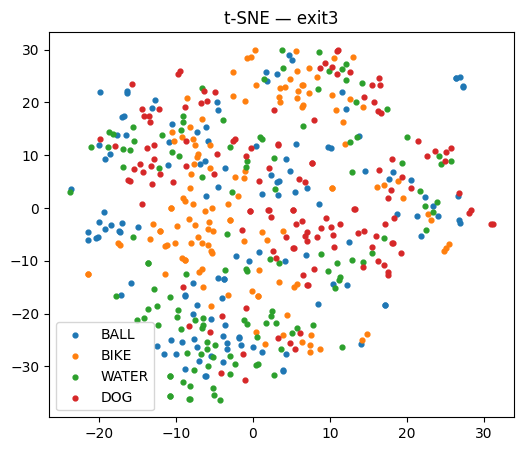

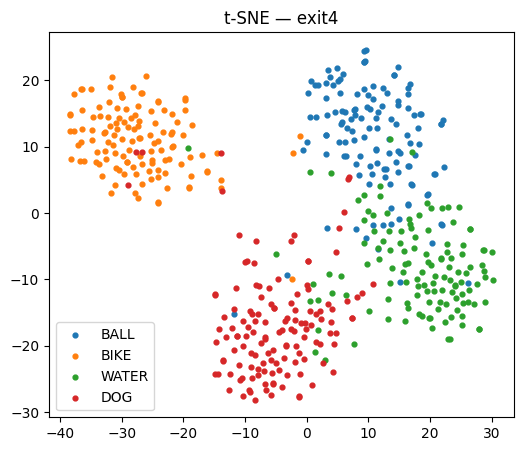

In [155]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(model, loader, class_names, max_samples=500):
    model.eval()
    feats = { "exit1": [], "exit2": [], "exit3": [], "exit4": [] }
    labels = []

    with torch.no_grad():
        for _, (idx, imgs, y) in enumerate(loader):
            imgs = imgs.to(device)

            features = model.extract_features(imgs)
            for k in feats.keys():
                feats[k].append(features[k].cpu().numpy())

            labels.append(y.numpy())
            if len(labels) * imgs.size(0) > max_samples:
                break

    for k in feats.keys():
        X = np.concatenate(feats[k], axis=0)
        Y = np.concatenate(labels, axis=0)

        X_2d = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(X)

        plt.figure(figsize=(6,5))
        for i, class_name in enumerate(class_names):
            pts = X_2d[Y == i]
            plt.scatter(pts[:,0], pts[:,1], s=12, label=class_name)

        plt.title(f"t-SNE — {k}")
        plt.legend()
        plt.show()

class_names = ["BALL", "BIKE", "WATER", "DOG"]
plot_tsne(model_resnet_custom, val_loader, class_names)


Collect misclassified:   0%|          | 0/20 [00:00<?, ?it/s]

Nb mauvaises prédictions (VAL): 63


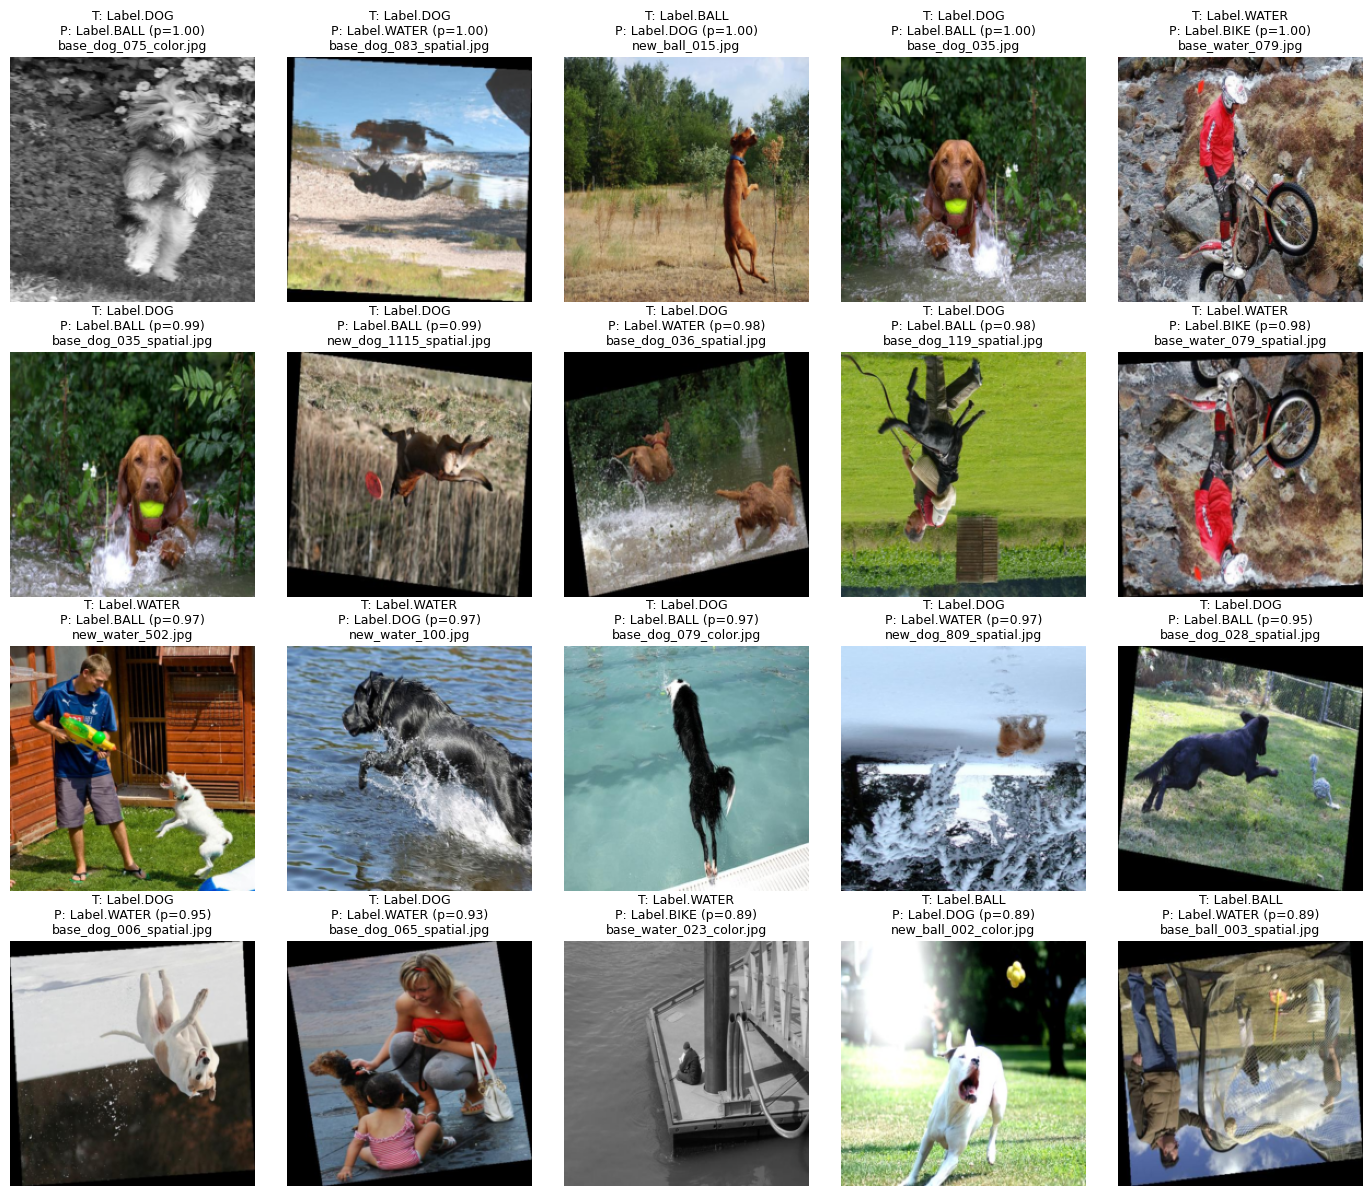

In [157]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denorm_img(x: torch.Tensor) -> torch.Tensor:
    x = x.detach().cpu() * IMAGENET_STD + IMAGENET_MEAN
    return x.clamp(0, 1)

def collect_misclassified(model, loader, dataset, device):
    model.eval()
    mis = []

    with torch.no_grad():
        for idxs, inputs, labels in tqdm(loader, desc="Collect misclassified", leave=False):
            # idxs reste CPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            if isinstance(output, (tuple, list)):
                logits = next((o for o in output if isinstance(o, torch.Tensor)), output[0])
            else:
                logits = output

            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            # ✅ masque sur CPU pour indexer idxs (CPU)
            wrong_mask_cpu = preds.ne(labels).detach().cpu()

            if wrong_mask_cpu.any():
                wrong_idxs  = idxs[wrong_mask_cpu].cpu().tolist()
                wrong_imgs  = inputs.detach().cpu()[wrong_mask_cpu]   # inputs est GPU -> on cpu puis masque cpu
                wrong_true  = labels.detach().cpu()[wrong_mask_cpu].tolist()
                wrong_pred  = preds.detach().cpu()[wrong_mask_cpu].tolist()
                wrong_probs = probs.detach().cpu().numpy()[wrong_mask_cpu.numpy()]

                for j, ds_idx in enumerate(wrong_idxs):
                    path = dataset._get_img_path_from_idx(ds_idx)
                    mis.append({
                        "idx": int(ds_idx),
                        "path": path,
                        "img": wrong_imgs[j],              # tensor normalisé (3,H,W) CPU
                        "true": int(wrong_true[j]),
                        "pred": int(wrong_pred[j]),
                        "pred_prob": float(wrong_probs[j][wrong_pred[j]]),
                        "true_prob": float(wrong_probs[j][wrong_true[j]]),
                        "probs": wrong_probs[j],
                    })

    return mis

def show_misclassified(mis, idx_to_class, max_images=16, ncols=4, figsize=(14, 12),
                      sort_by="pred_prob", descending=True):
    if len(mis) == 0:
        print("✅ Aucune mauvaise prédiction.")
        return

    if sort_by is not None:
        mis = sorted(mis, key=lambda d: d.get(sort_by, 0.0), reverse=descending)

    n = min(len(mis), max_images)
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=figsize)
    for i in range(n):
        item = mis[i]
        img = denorm_img(item["img"])
        img_np = img.permute(1, 2, 0).numpy()

        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img_np)
        plt.title(
            f"T: {idx_to_class[item['true']]}\n"
            f"P: {idx_to_class[item['pred']]} (p={item['pred_prob']:.2f})\n"
            f"{item['path'].name}",
            fontsize=9
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---- Utilisation ----
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

mis_val = collect_misclassified(model_resnet_custom, val_loader, val_dataset, device)
print("Nb mauvaises prédictions (VAL):", len(mis_val))

show_misclassified(mis_val, idx_to_class, max_images=20, ncols=5, sort_by="pred_prob", descending=True)
